# Multi-agents

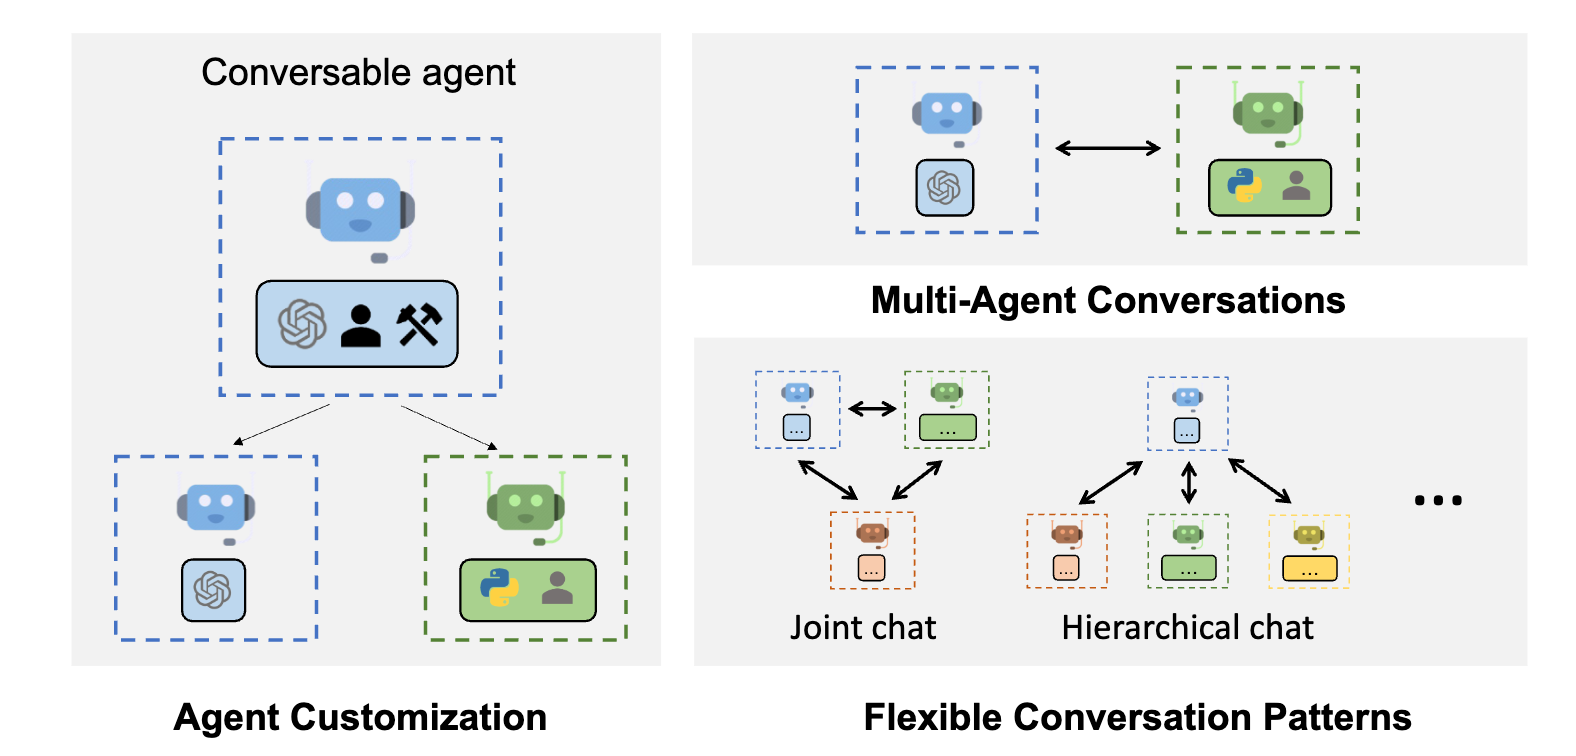



This time, we are going to use several agents that will work together to accomplish a task provided by the user. Let's focus on a simple task for which you might have already used an LLM. Let's ask chatGPT to write a short blogpost about a specific asset. 

## Single agent refinement

We'll first start by using a single agent and ask it to refine its own work. This will work, but it will have some limitations... If we start asking the writer to refine too many aspects of the post, we'll start noticing that it will have a hard time considering them all without forgetting any aspect. 

Let's try this out with a single agent:

In [ ]:
llm_config = {
    "model": "gpt-3.5-turbo", 

    }

In [6]:
task = '''
        Write a concise but engaging blogpost about
       udemy.com. Make sure the blogpost is
       within 200 words.
       '''

After defining our task, we can now create a writer agent. This writer agent will also be asked to refine its own work.

In [7]:
import autogen

writer = autogen.AssistantAgent(
    name="Writer",
    system_message="You are a writer. You write engaging and concise " 
        "blogposts (with title) on given topics. You must polish your "
        "writing based on the feedback you receive and give a refined "
        "version. Only return your final work without additional comments.",
    llm_config=llm_config,
)

Let's now use the simple `generate_reply()` function to get the single writer agent to work on this task.

In [8]:
reply = writer.generate_reply(messages=[{"content": task, "role": "user"}])
print(reply)

Title: Unleash Your Potential with Udemy: Your Gateway to Learning Success

Are you looking to expand your knowledge or acquire new skills from the comfort of your own home? Look no further than Udemy.com – the ultimate online learning platform that offers a diverse range of courses for every learner.

With Udemy, the possibilities are endless. Whether you want to master coding, delve into digital marketing, or learn a new language, there is a course tailored just for you. The platform provides engaging video lectures, interactive assignments, and the opportunity to connect with instructors and classmates from around the world.

One of the greatest advantages of Udemy is its flexibility. You can learn at your own pace, on your schedule, making it ideal for busy professionals or students. Plus, once you enroll in a course, you have lifetime access to the materials, allowing you to revisit and review whenever you need.

Don't let limitations hold you back. Join the millions of learners a

And we have our result. Now if we want to refine different aspects and ask a single agent to do so, the writer will have a hard time covering them all... To address this limitation we can use a sequential chat of agents each specialized in refining a different aspect of the blogpost. Let's try it out.

## Two-agents reflection: refinement

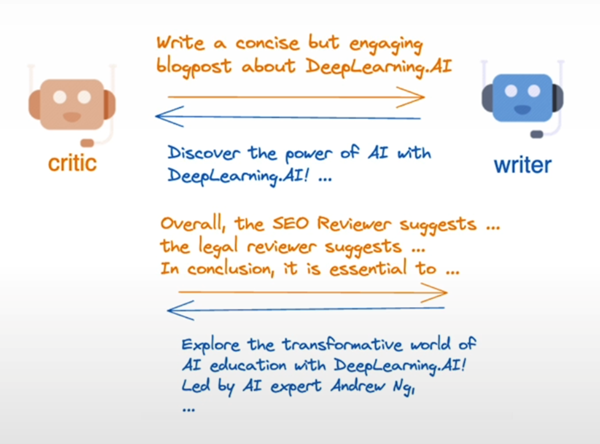

This time we're going to create a chat with two agents:
* The Writer who's going to write the blogpost
* The Critic who's going to reflect on the work of the writer and provide constructive criticism

Since each agent will be focused on a single aspect of the task, this will give us a better result for each aspect, which should yield a task that is better fulfilled. 

The agents will acomplish the same task, so we won't need to update that, but we need to re-define our agents:

In [9]:
writer = autogen.AssistantAgent(
    name="Writer",
    system_message="You are a writer. You write engaging and concise " 
        "blogposts (with title) on given topics. You must polish your "
        "writing based on the feedback you receive from other agents and give a refined "
        "version. Only return your final work without additional comments.",
    llm_config=llm_config,
)

critic = autogen.AssistantAgent(
    name="Critic",
    llm_config=llm_config,
    system_message="You are a critic. You review the work of "
                "the writer and provide constructive "
                "feedback to help improve the quality of the content.",
)



We will initiate the chat by getting the critic to send a message, the task we specified earlier, to the writer. The writer will then answer the critic with a first proposal, the critic will provide constructive criticism, and they will do this for two rounds.

We'll specify that the summary method is the last message, because that should be the last version of refined article. This will allow us to easily pass this result to another app or function that could then publish it or do what we want to do with this blogpost.

In [ ]:
chat_result = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"   #this means if we ask for the summary later, we will get the last message of our agentic chat i.e after critic-writer dicussion the final message will be the refined Blogpost there we use it as the final summary
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       udemy.com. Make sure the blogpost is
       within 200 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: "Unlock Your Potential with Udemy: A Comprehensive Learning Platform"
Are you looking to expand your knowledge and skills? Look no further than Udemy.com, a treasure trove of online courses waiting for you to explore. With over 130,000 courses covering a wide range of subjects, Udemy offers something for everyone, whether you're a budding entrepreneur, a tech enthusiast, or a creative soul.

One of the best things about Udemy is the flexibility it provides. You can learn at your own pace, anytime, anywhere. The courses are designed by experts in their respective fields, ensuring high-quality content that is both engaging and informative. From web development to photography, marketing to personal development, Udemy has it all.

Wh

And there we go! We have a refined article!  
We can now explore the last message which is our final version of the blogpost through the summary:

In [11]:
import pprint

pprint.pprint(chat_result.summary)

('Title: "Unlock Your Potential with Udemy: A Comprehensive Learning '
 'Platform"\n'
 'Embark on a journey of continuous learning with Udemy.com, a virtual hub '
 'brimming with over 130,000 diverse courses to hone your skills and expand '
 "your horizons. Whether you're a tech aficionado, a creative spirit, or a "
 'professional seeking growth, Udemy has the tools to nurture your passions.\n'
 '\n'
 'Experience the freedom of self-paced learning on Udemy, crafted by industry '
 'experts to deliver top-notch, engaging content. From web development to '
 'photography, marketing to personal growth, the array of courses caters to '
 'every interest and aspiration.\n'
 '\n'
 'What makes Udemy irresistible is its accessibility. With frequent discounts '
 'and lifetime access to course materials post-enrollment, knowledge '
 'acquisition becomes both affordable and enduring. However, remember that '
 'while Udemy is a treasure trove of education, some challenges like varying '
 'course qual

## Nested chats: multi-agent refinement

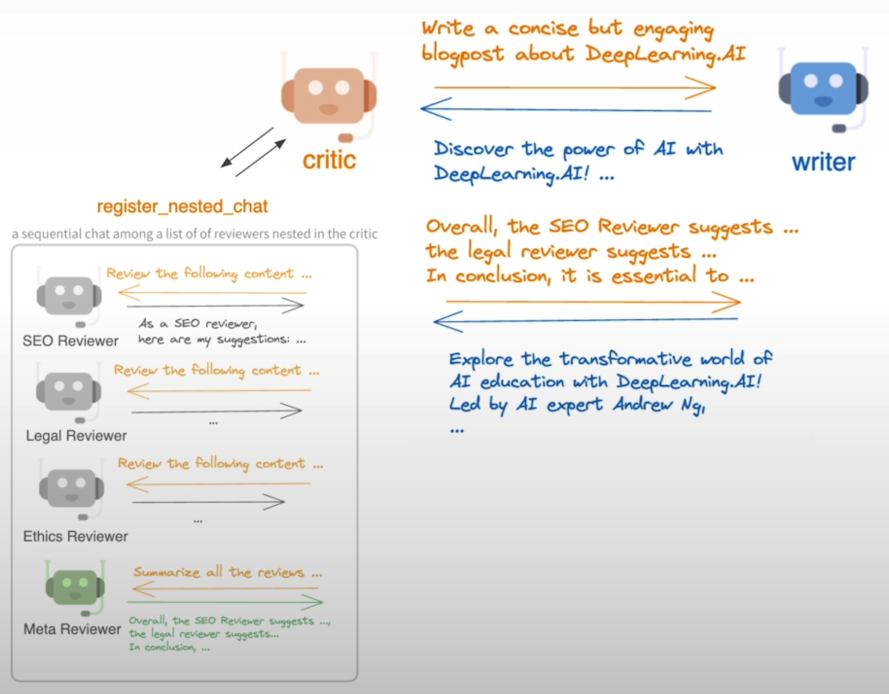

### Additional reviewers

We can now improve our refinement by using multiple agent that each specialize in a specific type of criticism and refinement. We're going to add 3 different types of critics:
* A **SEO reviewer**: This reviewer will provide improvements to optimize the content produced for search engines
* A **Legal reviewer**: This reviewer will provide criticisms to ensure that the content produced is legally compliant
* An **Ethics reviewer**: This reviewer will ensure that the content is ethically sound

The right way to think about this is that all these agents are virtually one agent, the critic. What will happen is that they will all provide their criticism for various aspects of the blogpost and report them back to the critic. The critic will then share them with the writer to get a better version. Now this might be a lot of criticism information, so we'll have to find a way to make it succint and clear for the writer, we'll see how to do that next;  
but first let's first these 3 additional reviewer agents:

In [12]:
SEO_reviewer = autogen.AssistantAgent(
    name="SEO_Reviewer",
    llm_config=llm_config,
    system_message="You are an SEO reviewer, known for "
        "your ability to optimize content for search engines, "
        "ensuring that it ranks well and attracts organic traffic. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)

legal_reviewer = autogen.AssistantAgent(
    name="Legal_Reviewer",
    llm_config=llm_config,
    system_message="You are a legal reviewer, known for "
        "your ability to ensure that content is legally compliant "
        "and free from any potential legal issues. "
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)

ethics_reviewer = autogen.AssistantAgent(
    name="Ethics_Reviewer",
    llm_config=llm_config,
    system_message="You are an ethics reviewer, known for "
        "your ability to ensure that content is ethically sound "
        "and free from any potential ethical issues. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role. ",
)

### Meta reviewer

Since all of these reviews is going to be a lot of data, we are going to add another agent who is going to play the role of a meta-reviewer, a reviewer that is going to gather the reviews of all other reviewers and provide a summary to the writer.

The meta-reviewer will be provided by the context (summary of each previous review in a structured format) and will use the summary of each previous review to propose a final set of reviews that gathers all previous ones to the critic, who will then report them to the writer.

In [13]:
meta_reviewer = autogen.AssistantAgent(
    name="Meta_Reviewer",
    llm_config=llm_config,
    system_message="You are a meta reviewer, you aggregate and review "
    "the work of other reviewers and give a final suggestion on the content.",
)

### Chat orchestration

#### Nested chats

The way our chat is going to work is that when the writer will answer the critic, this time, the critic will actually trigger a series of nested chats with each specialized reviewer (Critic -> Reviewer and then Reviewer -> Critic). We are also going to request from each reviewer that they send back their review in a specific format. Each review will send back a LLM generated summary of their review in the following JSON format:  
`{'Reviewer': '', 'Review': ''}`  
This will make it easier for the meta-reviewer to summarize all reviews.

We will also define here is a simple function called `reflection_message()` that will create the following nessage:
```
Review the following content.

"BLOGPOST PROPOSED BY WRITER"
```
We will call this function to create the message sent by the Critic to each specialized reviewer sequentially.

In [14]:
#this fuction will review the content
def reflection_message(recipient, messages, sender, config):
    return f'''Review the following content. 
            \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}'''

We are now going to define a new type of chat, a nested chat, that will trigger when the critic receives an answer. You can think about it like the inner monologue the Critic is having with other Reviewers that will help him provide the best possible criticism of the blogpost written by the reviewer. This is the structure our chat will follow:

**Main chat**:  
1. Critic -> Writer : Initial task (*"Write a concise but engaging blogpost ..."*)
2. Writer -> Critic : First version of the `blogpost`, this will trigger the **nested chat**

**Nested chat**:
1. Critic -> SEO reviewer: *"Review the following content: `blogpost`"*
2. SEO reviewer -> Critic: `SEO review` with context `{'Reviewer': '', 'Review': ''}` 
3. Critic -> Legal reviewer: *"Review the following content: `blogpost`"*
4. Legal reviewer -> Critic: `Legal review` with context `{'Reviewer': '', 'Review': ''}` 
5. Critic -> Ethics reviewer: *"Review the following content: `blogpost`"*
6. Ethics reviewer -> Critic: `Ethics review` with context `{'Reviewer': '', 'Review': ''}` 
7. Critic -> Meta reviewer: *"Aggregrate feedback from all reviewers and give final suggestions on the writing."*
8. Meta reviewer -> Critic: Summary of all reviews with all contexts `{'Reviewer': '', 'Review': ''}`

**Enf of nested chat**

**Back to the main chat**:
1. Critic -> Writer : Summary of all reviews with all contexts `{'Reviewer': '', 'Review': ''}`
2. Writer -> Critic : Refined version of the blogpost based on all reviews.

Since we've already seen how to define chats one by one, we'll define our nested chat all at once in a list this time:

In [15]:
review_chats = [ # This is our nested chat
    {
     "recipient": SEO_reviewer, 
     "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": 
        {
        "summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}. Here Reviewer should be your role",
        },
     "max_turns": 1},
    
    {
     "recipient": legal_reviewer, 
     "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}.",},
     "max_turns": 1},
    
    {"recipient": ethics_reviewer, 
     "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'reviewer': '', 'review': ''}",},
     "max_turns": 1},
    
     {"recipient": meta_reviewer, 
      "message": "Aggregrate feedback from all reviewers and give final suggestions on the writing.", 
      "max_turns": 1},
]

* Note how the `message` for each nested chat is going to be constructed by the `reflection_message() function we previously defined
* Note how each specialized reviewer will send back their review in the requested JSON format `{'reviewer': '', 'review': ''}`

We now need to save and register this nested chat as a chat that will be **triggered when the writer will contact the critic**:

In [16]:
critic.register_nested_chats(
    review_chats,
    trigger=writer,
)

#### Main chat

Ok, we are now ready to start this chat. We will start this with the main chat that will trigger the Critic's nested chat as soon as the writed send back an first proposal blogpost answer to the critic.

Pay attention to the order in which the exchanges will happen and feel free to go back to the orchestration structure presented above to ensure that you understand how the nested chat works:

In [17]:
chat_results = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       udemy.com. Make sure the blogpost is
       within 200 words.
       

--------------------------------------------------------------------------------


Writer (to Critic):

Title: "Unlock Your Potential with Udemy: A Comprehensive Learning Platform"
Are you looking to expand your knowledge and skills? Look no further than Udemy.com, a treasure trove of online courses waiting for you to explore. With over 130,000 courses covering a wide range of subjects, Udemy offers something for everyone, whether you're a budding entrepreneur, a tech enthusiast, or a creative soul.

One of the best things about Udemy is the flexibility it provides. You can learn at your own pace, anytime, anywhere. The courses are designed by experts in their respective fields, ensuring high-quality content that is both engaging and informative. From web development to photography, marketing to personal development, Udemy has it all.

What sets Udemy apart is its affordability. With frequent discounts and promotions, you can master new skills without breaking the bank. Plus, once you enroll in a course, you have lifetime access to the materials, allowing you to revi

And there you go! We have a final blgopost version that was reviewed by several specialized reviewers!

## Why does this matter?

One of the main weaknesses of LLMs like chatGPT, as you probably have noticed yourself if you've been using them, is that:
* when provided with complex tasks composed of several requirements, the LLM will most likely not accomplish all requirements properly: with nested chats, you can ensure that all requirements are all considered.
* LLMs very rarely directly provide the result you want in one step, you then have to keep asking them for specific refinements on the initial content: with nested chats, if you often ask for the same type of refinements, you can automatize this process to always accomplish these refinements.